<a href="https://colab.research.google.com/github/shayanAbbasi1995/Non-financial-misconduct-and-Market-reaction/blob/main/Copy_of_Copy_of_Copy_of_Copy_of_Final_MarketMicrostructure.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#DATA and LIBs

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Run this if running in Google Collab
# Mount google drive if running from Google Collab
from google.colab import drive
drive.mount('/content/drive')

# Set current directory if running from Google Collab

import os
os.chdir('/content/drive/My Drive/Colab Notebooks/SP500')# here use your path to current notebook

Mounted at /content/drive


In [ ]:
import pandas as pd
# SP500 data
mic_sample_pos = pd.read_excel('./mic_sample_pos.xlsx') # DAtaset was for 2016-2020
mic_sample_neg = pd.read_excel('./mic_sample_neg.xlsx')
date_ts = pd.read_csv('./INDEXES.csv').DATE

# Main Functions

In [ ]:
def clean_df(df):
  mean_ask = df.ASK.mean()
  mean_bid = df.BID.mean()
  mask1 = (df.ASK > mean_ask*0.5) | (df.BID > mean_bid*0.5)
  mask2 = (df.ASK > 0.) & (df.BID > 0.)
  df = df[mask1]
  df = df[mask2]
  return df

In [ ]:
def get_win_df(date_ts, df, ev_date, win=20):
  '''
  ev_date is in '20170105' format.
  '''
  lower_bound = date_ts.index[date_ts >= int(ev_date)][0]-win-2
  upper_bound = date_ts.index[date_ts >= int(ev_date)][0]+win+1
  mask1 = df.DATE>date_ts[lower_bound]
  mask2 = df.DATE<date_ts[upper_bound]
  return df[mask1][mask2]
  '''
  the result will be a column of date and a column of ticker returns
  '''
  return result #returns df of date and return for the specific return

In [ ]:
def get_data(date_ts, ticker, date, ev_win=20): #ev_win is an int like 20
    int_date = int(str(date)[0:4]+str(date)[5:7]+str(date)[8:10])
    temp_df1 = clean_df(pd.read_csv(f'./Micro data/NEG/{ticker}_{str(date)[0:4]}_{str(date)[5:7]}_{str(date)[8:10]}/1.csv'))
    temp_df2 = clean_df(pd.read_csv(f'./Micro data/NEG/{ticker}_{str(date)[0:4]}_{str(date)[5:7]}_{str(date)[8:10]}/2.csv'))
    df = temp_df1.append(temp_df2, ignore_index=True)
    del temp_df1
    del temp_df2
    try:
        temp_df3 = clean_df(pd.read_csv(f'./Micro data/NEG/{ticker}_{str(date)[0:4]}_{str(date)[5:7]}_{str(date)[8:10]}/3.csv'))
        df = df.append(temp_df3, ignore_index=True)
        del temp_df3
    except:
        pass
    df.DATE = pd.to_datetime(df.DATE, format='%Y%m%d')
    df.TIME_M = pd.to_timedelta(df.TIME_M)
    return df.drop(['SYM_SUFFIX'], axis=1)

In [ ]:
def get_trade(date_ts, ticker, date, ev_win=20):
    trade = pd.read_csv(f'./Micro data/NEG trade/{ticker}_{str(date)[0:4]}_{str(date)[5:7]}_{str(date)[8:10]}/1.csv')
    try:
        temp_df = pd.read_csv(f'./Micro data/NEG trade/{ticker}_{str(date)[0:4]}_{str(date)[5:7]}_{str(date)[8:10]}/2.csv')
        trade = trade.append(temp_df, ignore_index=True)
        del temp_df
    except:
        pass
    trade.DATE = pd.to_datetime(trade.DATE, format='%Y%m%d')
    trade.TIME_M = pd.to_timedelta(trade.TIME_M)
    return trade.drop(['SYM_SUFFIX'], axis=1)

In [ ]:
import time

def cal_vars(df, trade_df):

  result = pd.DataFrame()
  df['midquote'] = (df.ASK+df.BID)/2
  df['qouted_spread'] = (df.ASK-df.BID)/(df['midquote'])
  

  trade_df['qouted_spread'] = np.nan
  trade_df['effective_spread'] = np.nan
  trade_df['midquote'] = np.nan
  trade_df['d'] = np.nan
  
  for i in range(0,len(trade_df.TIME_M)):
    temp = df[df.DATE == trade_df.DATE.iloc[i]]
    mask2 = trade_df.TIME_M.iloc[i] >= temp.TIME_M 
    try:
      trade_df['midquote'].iloc[i] = temp[mask2].midquote.iloc[-1]
    except:
      trade_df['midquote'].iloc[i] = None
    try:
      trade_df['qouted_spread'].iloc[i] = np.abs(temp[mask2].qouted_spread.iloc[-1])
    except:
      pass
    #print(f'price={trade_df.PRICE.iloc[i]}  mid={trade_df.midquote.iloc[i]},  time={trade_df.TIME_M.iloc[i]},   date={trade_df.DATE.iloc[i]}')

  for i in range(1,len(trade_df.TIME_M)):
    if (trade_df.PRICE.iloc[i] != trade_df.midquote.iloc[i-1])\
    and (trade_df.PRICE.iloc[i]>trade_df.midquote.iloc[i]):
      trade_df.d.iloc[i] = 1
    elif (trade_df.PRICE.iloc[i] != trade_df.midquote.iloc[i-1])\
    and (trade_df.PRICE.iloc[i]<trade_df.midquote.iloc[i]):
      trade_df.d.iloc[i] = -1
    elif (trade_df.PRICE.iloc[i] == trade_df.midquote.iloc[i-1])\
    and (trade_df.PRICE.iloc[i]>trade_df.PRICE.iloc[i-1]):
      trade_df.d.iloc[i] = 1
    elif (trade_df.PRICE.iloc[i] == trade_df.midquote.iloc[i-1])\
    and (trade_df.PRICE.iloc[i]<trade_df.PRICE.iloc[i-1]):
      trade_df.d.iloc[i] = -1
    else:
      trade_df.d.iloc[i] = None

  trade_df.d.fillna(method='ffill')

  start = time.time()
  trade_df['effective_spread'] =  2 * (trade_df.PRICE - trade_df.midquote) * trade_df.d

  delta_30m = pd.Timedelta(1800000000000)

  trade_df['realized_spread_30m'] = np.nan

  for i in range(1,len(trade_df.TIME_M)):
    try:
      trade_df['realized_spread_30m'].iloc[i] = 2 * (trade_df.PRICE.iloc[i] - trade_df[trade_df.TIME_M > trade_df.TIME_M.iloc[i]+delta_30m].midquote.iloc[0]) * trade_df.d.iloc[i]
    except:
      trade_df['realized_spread_30m'].iloc[i] = None

  trade_df['price_impact_30m'] = trade_df['effective_spread'] - trade_df['realized_spread_30m']

  trade_df['illiquid_ratio'] = np.nan
  for i in range(1,len(trade_df.TIME_M)):
    trade_df['illiquid_ratio'].iloc[i] = (np.abs(np.log(trade_df.PRICE.iloc[i]) - np.log(trade_df.PRICE.iloc[i-1])))/(trade_df.SIZE.iloc[i]*trade_df.PRICE.iloc[i])
  return trade_df

In [ ]:
def make_daily_agg_vars(time_array, cols, result):
  agg_result = pd.DataFrame()
  agg_result['time'] = range(len(time_array)-1)
  for k in cols:
    agg_result[k] = np.nan
  print(agg_result)
  for j in range(len(cols)):
    for i in range(1,len(time_array)):
      low_bound_mask = result.TIME_M>time_array[i-1]
      high_bound_mask = result.TIME_M<time_array[i]
      agg_result.iloc[i-1, j+1] = result[low_bound_mask][high_bound_mask][cols[j]].mean(skipna=True)
  return agg_result

In [ ]:
def missing_rep(df, ticker, ev_date):
  print(df.shape)
  df.replace([np.inf, -np.inf], np.nan)
  Nulls = df.isnull().sum()
  plt.figure(figsize=(20,8))
  plt.xticks(rotation="vertical")
  plt.bar(Nulls.index, 100*Nulls.values/len(df.index))
  plt.ylabel("% of missing data")
  plt.title(f'Missing report for {ticker} at {ev_date}')
  plt.show()
  

In [ ]:
def get_eve_win_agg_vars(date_ts, ticker, eve_date, MM_cols, delta=pd.Timedelta(1800000000000), num_intraday_period =14, num_delta=19, missing_report=False, null_report=False, plot_vars=False, HP_filter=False):
  print(f'The process for Ticker {ticker} begins')
  trade_df = get_trade(date_ts, ticker, eve_date)
  df = get_data(date_ts, ticker, eve_date)
  win_date = list(trade_df.DATE.value_counts().index.sort_values())
  '''
  if missing_report==True:
    print('Missing report for consolidated qoutes')
    missing_rep(df, ticker, ev_date)
    print('Missing report for consolidated trades')
    missing_rep(trade_df, ticker, ev_date)
  '''

  agg_eve_vars = pd.DataFrame()
  if os.path.isfile(f'./Micro data/NEG/{ticker}_{str(eve_date)[0:4]}_{str(eve_date)[5:7]}_{str(eve_date)[8:10]}/Partial result.xlsx'):
    print ("Partial File exist")
    agg_eve_vars = pd.read_excel(f'./Micro data/NEG/{ticker}_{str(eve_date)[0:4]}_{str(eve_date)[5:7]}_{str(eve_date)[8:10]}/Partial result.xlsx').iloc[:,1:]
    for i in range(int(agg_eve_vars.shape[0]/13)):
      win_date.pop(0)
  
  for date in win_date:
    result = cal_vars(df[df.DATE == date], trade_df[trade_df.DATE == date])

    time_array = [pd.to_timedelta(delta*num_delta)]
    for i in range(num_intraday_period-1):
      time_array.append(time_array[i]+delta)

    agg_result = make_daily_agg_vars(time_array, MM_cols, result)
    '''
    if missing_report==True:
      print('Missing report for Mictostructure variables')
      missing_rep(result, f'{ticker}_result', date)
      print('Missing report for AGG variables')
      missing_rep(result, f'{ticker}_result_agg', date)
    '''
    agg_eve_vars = agg_eve_vars.append(agg_result, ignore_index=True)
    print(f'Process completed for {date}')
    # create excel writer object
    writer = pd.ExcelWriter(f'./Micro data/NEG/{ticker}_{str(eve_date)[0:4]}_{str(eve_date)[5:7]}_{str(eve_date)[8:10]}/Partial result.xlsx')
    # write dataframe to excel
    agg_eve_vars.to_excel(writer)
    # save the excel
    writer.save()
  return agg_eve_vars

#Implementing

In [ ]:
def run(date_ts, mic_sample_neg):

  MM_cols = ['SIZE', 'PRICE', 'qouted_spread', 'effective_spread', 'midquote', 'realized_spread_30m', 'price_impact_30m', 'illiquid_ratio']
  for ticker,eve_date in zip(mic_sample_neg.ticker,mic_sample_neg.date):
    if os.path.isfile(f'./Micro data/NEG/{ticker}_{str(eve_date)[0:4]}_{str(eve_date)[5:7]}_{str(eve_date)[8:10]}/Agg_result.xlsx'):
      print (f"File exist for {ticker}_{str(eve_date)[0:4]}_{str(eve_date)[5:7]}_{str(eve_date)[8:10]}")
    else:
      print ("File not exist")
      eve_add_df = get_eve_win_agg_vars(date_ts, ticker, eve_date, MM_cols, delta=pd.Timedelta(1800000000000), num_delta=19, missing_report=False, null_report=False, plot_vars=False, HP_filter=False)
      # create excel writer object
      writer = pd.ExcelWriter(f'./Micro data/NEG/{ticker}_{str(eve_date)[0:4]}_{str(eve_date)[5:7]}_{str(eve_date)[8:10]}/Agg_result.xlsx')
      # write dataframe to excel
      eve_add_df.to_excel(writer)
      # save the excel
      writer.save()

In [ ]:
run(date_ts, mic_sample_neg.iloc[19:20])

File not exist
The process for Ticker VZ begins


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


Partial File exist


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

    time  SIZE  PRICE  ...  realized_spread_30m  price_impact_30m  illiquid_ratio
0      0   NaN    NaN  ...                  NaN               NaN             NaN
1      1   NaN    NaN  ...                  NaN               NaN             NaN
2      2   NaN    NaN  ...                  NaN               NaN             NaN
3      3   NaN    NaN  ...                  NaN               NaN             NaN
4      4   NaN    NaN  ...                  NaN               NaN             NaN
5      5   NaN    NaN  ...                  NaN               NaN             NaN
6      6   NaN    NaN  ...                  NaN               NaN             NaN
7      7   NaN    NaN  ...                  NaN               NaN             NaN
8      8   NaN    NaN  ...                  NaN               NaN             NaN
9      9   NaN    NaN  ...                  NaN               NaN             NaN
10    10   NaN    NaN  ...                  NaN               NaN             NaN
11    11   NaN  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


Process completed for 2020-01-29 00:00:00


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

    time  SIZE  PRICE  ...  realized_spread_30m  price_impact_30m  illiquid_ratio
0      0   NaN    NaN  ...                  NaN               NaN             NaN
1      1   NaN    NaN  ...                  NaN               NaN             NaN
2      2   NaN    NaN  ...                  NaN               NaN             NaN
3      3   NaN    NaN  ...                  NaN               NaN             NaN
4      4   NaN    NaN  ...                  NaN               NaN             NaN
5      5   NaN    NaN  ...                  NaN               NaN             NaN
6      6   NaN    NaN  ...                  NaN               NaN             NaN
7      7   NaN    NaN  ...                  NaN               NaN             NaN
8      8   NaN    NaN  ...                  NaN               NaN             NaN
9      9   NaN    NaN  ...                  NaN               NaN             NaN
10    10   NaN    NaN  ...                  NaN               NaN             NaN
11    11   NaN  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


Process completed for 2020-01-30 00:00:00


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

# TEST

In [ ]:
df = clean_df(get_data(date_ts, 'SRCL', '2018-08-03 00:00:00'))

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


In [ ]:
trade_df = get_trade(date_ts, 'SRCL', '2018-08-03 00:00:00')

In [ ]:
cal_vars(df[df.DATE=='2018-08-07'], trade_df[trade_df.DATE=='2018-08-07'])

In [ ]:
trade_df

,DATE,TIME_M,SYM_ROOT,SIZE,PRICE
0,2018-07-05,0 days 09:30:00.175729634,SRCL,100,63.085
1,2018-07-05,0 days 09:30:00.341031190,SRCL,35,64.690
2,2018-07-05,0 days 09:30:00.853526799,SRCL,25,64.690
3,2018-07-05,0 days 09:30:01.113417668,SRCL,4933,65.210
4,2018-07-05,0 days 09:30:01.113427845,SRCL,4933,65.210
...,...,...,...,...,...
362140,2018-09-04,0 days 15:59:01.684614188,SRCL,43,45.530
362141,2018-09-04,0 days 15:59:01.740168055,SRCL,43,45.530
362142,2018-09-04,0 days 15:59:07.727692503,SRCL,136,45.540
362143,2018-09-04,0 days 15:59:07.945632512,SRCL,200,45.540


In [ ]:
(df.ASK+df.BID)/2

0          63.315
1          63.630
2          63.085
3          63.495
4          62.270
            ...  
4900454    45.420
4900455    45.570
4900456    45.420
4900457    45.570
4900458    45.570
Length: 4900459, dtype: float64

In [ ]:
df

,DATE,TIME_M,BID,BIDSIZ,ASK,ASKSIZ,SYM_ROOT
0,2018-07-05,0 days 09:30:00.033688152,58.99,1,67.64,1,SRCL
1,2018-07-05,0 days 09:30:00.116973537,60.40,2,66.86,1,SRCL
2,2018-07-05,0 days 09:30:00.127899530,60.50,1,65.67,2,SRCL
3,2018-07-05,0 days 09:30:00.128069779,50.82,1,76.17,1,SRCL
4,2018-07-05,0 days 09:30:00.230943010,58.08,2,66.46,1,SRCL
...,...,...,...,...,...,...,...
4900454,2018-09-04,0 days 15:59:58.038377457,45.22,1,45.62,11,SRCL
4900455,2018-09-04,0 days 15:59:58.038844487,45.52,10,45.62,11,SRCL
4900456,2018-09-04,0 days 15:59:58.084629704,45.22,1,45.62,1,SRCL
4900457,2018-09-04,0 days 15:59:58.088133506,45.52,7,45.62,1,SRCL


In [ ]:
df['midquote'] = (df.ASK+df.BID)/2
df['qouted_spread'] = (df.ASK-df.BID)/(df['midquote'])
i = 0
trade_df['qouted_spread'] = np.nan
trade_df['effective_spread'] = np.nan
trade_df['midquote'] = np.nan
trade_df['d'] = np.nan

temp = df[df.DATE == trade_df.DATE.iloc[i]]
mask2 = trade_df.TIME_M.iloc[i] >= temp.TIME_M 
try:
  trade_df['midquote'].iloc[i] = temp[mask2]['midquote'].iloc[-1]
except:
  trade_df['midquote'].iloc[i] = None
try:
  trade_df['qouted_spread'].iloc[i] = np.abs(temp[mask2]['qouted_spread'].iloc[0])
except:
  pass

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
trade_df

,DATE,TIME_M,SYM_ROOT,SIZE,PRICE,qouted_spread,effective_spread,midquote,d
0,2018-07-05,0 days 09:30:00.175729634,SRCL,100,63.085,0.136618,NaN,63.495,NaN
1,2018-07-05,0 days 09:30:00.341031190,SRCL,35,64.690,NaN,NaN,NaN,NaN
2,2018-07-05,0 days 09:30:00.853526799,SRCL,25,64.690,NaN,NaN,NaN,NaN
3,2018-07-05,0 days 09:30:01.113417668,SRCL,4933,65.210,NaN,NaN,NaN,NaN
4,2018-07-05,0 days 09:30:01.113427845,SRCL,4933,65.210,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
362140,2018-09-04,0 days 15:59:01.684614188,SRCL,43,45.530,NaN,NaN,NaN,NaN
362141,2018-09-04,0 days 15:59:01.740168055,SRCL,43,45.530,NaN,NaN,NaN,NaN
362142,2018-09-04,0 days 15:59:07.727692503,SRCL,136,45.540,NaN,NaN,NaN,NaN
362143,2018-09-04,0 days 15:59:07.945632512,SRCL,200,45.540,NaN,NaN,NaN,NaN


In [ ]:
mask2 = (temp.TIME_M  <= trade_df.TIME_M.iloc[i])
temp[mask2]

,DATE,TIME_M,BID,BIDSIZ,ASK,ASKSIZ,SYM_ROOT,midquote,qouted_spread
0,2018-07-05,0 days 09:30:00.033688152,58.99,1,67.64,1,SRCL,63.315,0.136618
1,2018-07-05,0 days 09:30:00.116973537,60.40,2,66.86,1,SRCL,63.630,0.101524
2,2018-07-05,0 days 09:30:00.127899530,60.50,1,65.67,2,SRCL,63.085,0.081953
3,2018-07-05,0 days 09:30:00.128069779,50.82,1,76.17,1,SRCL,63.495,0.399244


In [ ]:
trade_df[trade_df.DATE=='2018-08-07']

,DATE,TIME_M,SYM_ROOT,SIZE,PRICE
229474,2018-08-07,0 days 09:30:00.357994787,SRCL,6161,62.110
229475,2018-08-07,0 days 09:30:00.358112111,SRCL,6161,62.110
229476,2018-08-07,0 days 09:30:00.387758175,SRCL,45,62.130
229477,2018-08-07,0 days 09:30:00.688947801,SRCL,100,62.110
229478,2018-08-07,0 days 09:30:01.894145495,SRCL,100,62.100
...,...,...,...,...,...
237534,2018-08-07,0 days 15:59:23.691246748,SRCL,1,47.055
237535,2018-08-07,0 days 15:59:23.691249927,SRCL,1,47.055
237536,2018-08-07,0 days 15:59:23.691254243,SRCL,2,47.055
237537,2018-08-07,0 days 15:59:23.691256845,SRCL,149,47.040


#Tests

In [ ]:
trade_df = get_trade(date_ts, 'ANTM', '2018-02-22 00:00:00')

In [ ]:
trade_df

,DATE,TIME_M,SYM_ROOT,SIZE,PRICE
0,2018-01-23,0 days 09:30:09.092674,ANTM,8477,250.47
1,2018-01-23,0 days 09:30:09.139348,ANTM,100,250.55
2,2018-01-23,0 days 09:30:09.143723,ANTM,48,250.50
3,2018-01-23,0 days 09:30:09.304677,ANTM,100,249.58
4,2018-01-23,0 days 09:30:09.321481,ANTM,100,250.60
...,...,...,...,...,...
725583,2018-03-23,0 days 15:59:59.306575,ANTM,18,215.65
725584,2018-03-23,0 days 15:59:59.313484,ANTM,18,215.65
725585,2018-03-23,0 days 15:59:59.313873,ANTM,18,215.65
725586,2018-03-23,0 days 15:59:59.380092,ANTM,122,215.65


In [ ]:
win_date = trade_df.DATE.value_counts().index.sort_values()
for i in win_date:
  print(i)

2018-01-23 00:00:00
2018-01-24 00:00:00
2018-01-25 00:00:00
2018-01-26 00:00:00
2018-01-29 00:00:00
2018-01-30 00:00:00
2018-01-31 00:00:00
2018-02-01 00:00:00
2018-02-02 00:00:00
2018-02-05 00:00:00
2018-02-06 00:00:00
2018-02-07 00:00:00
2018-02-08 00:00:00
2018-02-09 00:00:00
2018-02-12 00:00:00
2018-02-13 00:00:00
2018-02-14 00:00:00
2018-02-15 00:00:00
2018-02-16 00:00:00
2018-02-20 00:00:00
2018-02-21 00:00:00
2018-02-22 00:00:00
2018-02-23 00:00:00
2018-02-26 00:00:00
2018-02-27 00:00:00
2018-02-28 00:00:00
2018-03-01 00:00:00
2018-03-02 00:00:00
2018-03-05 00:00:00
2018-03-06 00:00:00
2018-03-07 00:00:00
2018-03-08 00:00:00
2018-03-09 00:00:00
2018-03-12 00:00:00
2018-03-13 00:00:00
2018-03-14 00:00:00
2018-03-15 00:00:00
2018-03-16 00:00:00
2018-03-19 00:00:00
2018-03-20 00:00:00
2018-03-21 00:00:00
2018-03-22 00:00:00
2018-03-23 00:00:00


In [ ]:
df = get_data(date_ts, 'ANTM', '2018-02-22 00:00:00')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


In [ ]:
df

,DATE,TIME_M,BID,BIDSIZ,ASK,ASKSIZ,SYM_ROOT
0,2018-01-23,0 days 09:30:00.016817,248.68,1,251.76,1,ANTM
1,2018-01-23,0 days 09:30:00.016935,248.68,1,251.76,2,ANTM
2,2018-01-23,0 days 09:30:00.017179,248.67,1,251.76,1,ANTM
3,2018-01-23,0 days 09:30:00.017245,248.22,1,251.76,1,ANTM
4,2018-01-23,0 days 09:30:00.019935,248.67,1,251.76,2,ANTM
...,...,...,...,...,...,...,...
6415752,2018-03-22,0 days 15:59:59.939095,218.79,1,218.85,59,ANTM
6415753,2018-03-22,0 days 15:59:59.939211,218.79,1,218.84,41,ANTM
6415754,2018-03-22,0 days 15:59:59.939332,218.75,1,218.84,1,ANTM
6415755,2018-03-22,0 days 15:59:59.939616,218.75,2,218.85,1,ANTM


(6415757, 7)


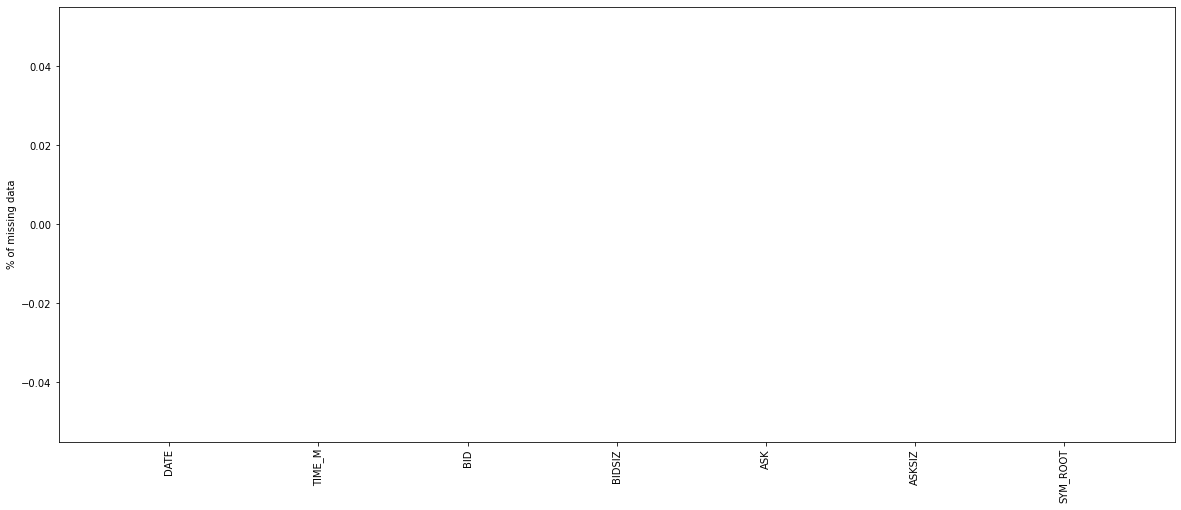

In [ ]:
# Missings report
df.replace([np.inf, -np.inf], np.nan)
Nulls = df.isnull().sum()
plt.figure(figsize=(20,8))
plt.xticks(rotation="vertical")
plt.bar(Nulls.index, 100*Nulls.values/len(df.index))
plt.ylabel("% of missing data")
print(df.shape)

In [ ]:
trade_df[trade_df.DATE == '2018-01-23']

,DATE,TIME_M,SYM_ROOT,SIZE,PRICE
0,2018-01-23,0 days 09:30:09.092674,ANTM,8477,250.47
1,2018-01-23,0 days 09:30:09.139348,ANTM,100,250.55
2,2018-01-23,0 days 09:30:09.143723,ANTM,48,250.50
3,2018-01-23,0 days 09:30:09.304677,ANTM,100,249.58
4,2018-01-23,0 days 09:30:09.321481,ANTM,100,250.60
...,...,...,...,...,...
11934,2018-01-23,0 days 15:59:59.628677,ANTM,16,250.50
11935,2018-01-23,0 days 15:59:59.630235,ANTM,100,250.50
11936,2018-01-23,0 days 15:59:59.717290,ANTM,92,250.50
11937,2018-01-23,0 days 15:59:59.760443,ANTM,39,250.51


(725588, 5)


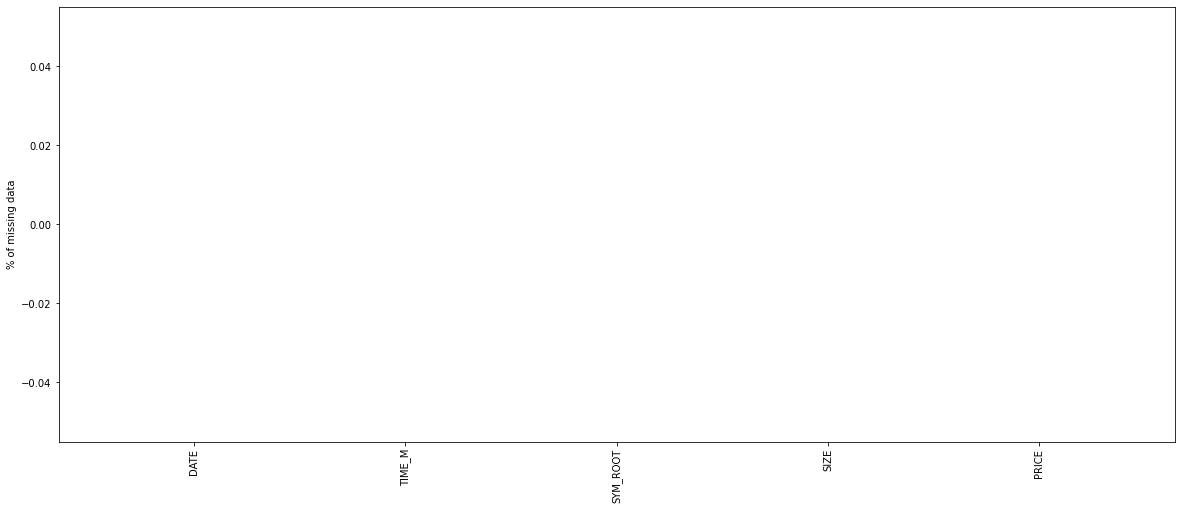

In [ ]:
# Missings report
trade_df.replace([np.inf, -np.inf], np.nan)
Nulls = trade_df.isnull().sum()
plt.figure(figsize=(20,8))
plt.xticks(rotation="vertical")
plt.bar(Nulls.index, 100*Nulls.values/len(trade_df.index))
plt.ylabel("% of missing data")
print(trade_df.shape)

In [ ]:
result = cal_vars(df[df.DATE == '2018-01-23'], trade_df[trade_df.DATE == '2018-01-23'])

hello
Initialization Finished
0.009070634841918945


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Finished midqoute merger
165.15318775177002


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to b

finished direction
2.889129638671875
finished effective spread
0.004230499267578125


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

finished realized spread
81.519695520401
finished price impacts
0.005427360534667969


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

finished illiquid ratio
2.727468967437744


In [ ]:
result

,DATE,TIME_M,SYM_ROOT,SIZE,PRICE,qouted_spread,effective_spread,midquote,d,relative_effective_spread,realized_spread_30s,realized_spread_1m,realized_spread_5m,realized_spread_10m,realized_spread_30m,price_impact_30s,price_impact_1m,price_impact_5m,price_impact_10m,price_impact_30m,illiquid_ratio
0,2018-01-23,0 days 09:30:09.092674,ANTM,8477,250.47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-01-23,0 days 09:30:09.139348,ANTM,100,250.55,0.014713,0.86,250.120,1.0,0.003438,0.43,0.21,1.36,2.26,1.90,0.43,0.65,-0.50,-1.40,-1.04,1.274590e-08
2,2018-01-23,0 days 09:30:09.143723,ANTM,48,250.50,0.005834,0.46,250.270,1.0,0.001838,0.33,0.11,1.26,2.16,1.80,0.13,0.35,-0.80,-1.70,-1.34,1.659854e-08
3,2018-01-23,0 days 09:30:09.304677,ANTM,100,249.58,0.007731,0.11,249.635,-1.0,0.000441,1.51,1.73,0.58,-0.32,0.04,-1.40,-1.62,-0.47,0.43,0.07,1.474243e-07
4,2018-01-23,0 days 09:30:09.321481,ANTM,100,250.60,0.014373,0.26,250.470,1.0,0.001038,0.53,0.31,1.46,2.36,2.00,-0.27,-0.05,-1.20,-2.10,-1.74,1.627509e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11934,2018-01-23,0 days 15:59:59.628677,ANTM,16,250.50,0.001637,0.07,250.465,1.0,0.000279,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00
11935,2018-01-23,0 days 15:59:59.630235,ANTM,100,250.50,0.000040,0.01,250.505,-1.0,0.000040,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00
11936,2018-01-23,0 days 15:59:59.717290,ANTM,92,250.50,0.000040,0.01,250.505,-1.0,0.000040,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00
11937,2018-01-23,0 days 15:59:59.760443,ANTM,39,250.51,0.000998,0.13,250.575,-1.0,0.000519,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.085958e-09


In [ ]:
pd.DataFrame(result.isnull().sum(axis=0))


,0
DATE,0
TIME_M,0
SYM_ROOT,0
SIZE,0
PRICE,0
qouted_spread,1
effective_spread,405
midquote,1
d,405
relative_effective_spread,405


In [ ]:
result.columns

Index(['DATE', 'TIME_M', 'SYM_ROOT', 'SIZE', 'PRICE', 'qouted_spread',
       'effective_spread', 'midquote', 'd', 'relative_effective_spread',
       'realized_spread_30s', 'realized_spread_1m', 'realized_spread_5m',
       'realized_spread_10m', 'realized_spread_30m', 'price_impact_30s',
       'price_impact_1m', 'price_impact_5m', 'price_impact_10m',
       'price_impact_30m', 'illiquid_ratio'],
      dtype='object')

In [ ]:
delta_30m = pd.Timedelta(1800000000000)
time_array = [pd.to_timedelta(delta_30m*19)]
for i in range(13):
  time_array.append(time_array[i]+delta_30m)

cols = ['SIZE', 'PRICE', 'qouted_spread',
       'effective_spread', 'midquote', 'relative_effective_spread',
       'realized_spread_30s', 'realized_spread_1m', 'realized_spread_5m',
       'realized_spread_10m', 'realized_spread_30m', 'price_impact_30s',
       'price_impact_1m', 'price_impact_5m', 'price_impact_10m',
       'price_impact_30m', 'illiquid_ratio']

agg_result = make_daily_agg_vars(time_array, cols, result)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


In [ ]:
agg_result

,time,SIZE,PRICE,qouted_spread,effective_spread,midquote,d,relative_effective_spread,realized_spread_30s,realized_spread_1m,realized_spread_5m,realized_spread_10m,realized_spread_30m,price_impact_30s,price_impact_1m,price_impact_5m,price_impact_10m,price_impact_30m,illiquid_ratio
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,91.986014,249.814689,0.003434,0.533070,249.767909,0.264654,0.002133,0.263425,0.032830,0.103852,0.261995,0.359411,0.269645,0.500240,0.429218,0.271075,0.173659,5.359491e-08
2,2,72.335729,249.219594,0.004111,0.691692,249.243075,0.112500,0.002771,0.022650,-0.050475,-0.196944,0.129025,-0.148360,0.669042,0.742167,0.888635,0.562667,0.840052,4.144661e-08
3,3,64.538202,249.862045,0.005435,1.193769,250.212225,0.046404,0.004716,-0.163980,-0.107019,0.048282,0.012516,-0.190627,1.357749,1.300789,1.145487,1.181253,1.384397,4.727875e-08
4,4,68.117718,249.923107,0.006206,1.265883,250.270843,-0.027569,0.005003,0.028891,0.430545,-0.494154,-0.215558,-0.111949,1.236992,0.835338,1.760038,1.481441,1.377832,6.450489e-08
5,5,83.954657,249.773461,0.005877,1.327515,250.213738,-0.008895,0.005235,-0.159626,-0.075331,-0.125509,-0.045725,-0.004823,1.487141,1.402846,1.453024,1.373240,1.332338,5.912058e-08
6,6,66.227704,249.442984,0.006629,1.338793,249.658643,-0.007782,0.005318,-0.048055,-0.219261,0.229260,0.170933,0.056926,1.386848,1.558054,1.109533,1.167860,1.281868,6.284800e-08
7,7,53.915217,249.427075,0.006099,1.377068,249.920967,0.104213,0.005431,-0.236724,0.077467,0.267179,0.065405,0.162788,1.613792,1.299601,1.109889,1.311663,1.214279,5.984043e-08
8,8,93.124805,249.012242,0.005636,1.122887,249.333666,-0.040128,0.004449,0.060126,0.156675,0.061635,0.133721,-0.151367,1.062761,0.966212,1.061252,0.989165,1.274254,4.417366e-08
9,9,62.971893,249.468270,0.005918,1.207017,249.936398,-0.075969,0.004771,-0.028286,0.194862,0.321885,0.016924,0.134412,1.235302,1.012155,0.885132,1.190093,1.072605,5.181795e-08


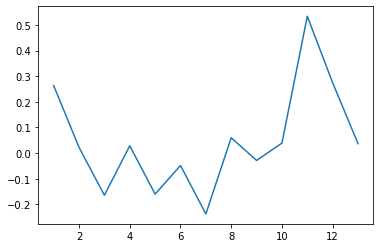

In [ ]:
plt.plot(agg_result.realized_spread_30s)

(11939, 21)


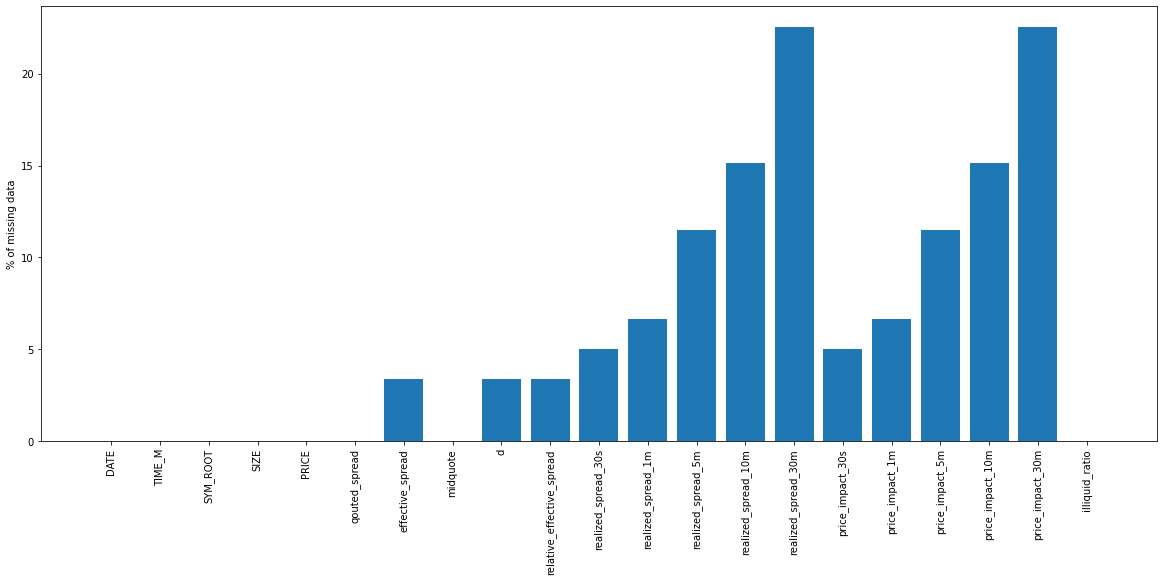

In [ ]:
# Missings report
result.replace([np.inf, -np.inf], np.nan)
Nulls = result.isnull().sum()
plt.figure(figsize=(20,8))
plt.xticks(rotation="vertical")
plt.bar(Nulls.index, 100*Nulls.values/len(result.index))
plt.ylabel("% of missing data")
print(result.shape)

(array([8.400e+01, 2.430e+02, 2.240e+02, 3.000e+00, 9.019e+03, 1.154e+03,
        8.100e+01, 1.680e+02, 3.340e+02, 3.000e+01]),
 array([-13.3  , -10.578,  -7.856,  -5.134,  -2.412,   0.31 ,   3.032,
          5.754,   8.476,  11.198,  13.92 ]),
 <a list of 10 Patch objects>)

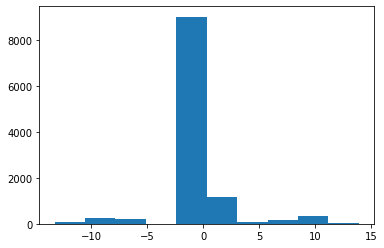

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

counts, bins = np.histogram(result.realized_spread_30s[result.realized_spread_30s.notna()])
plt.hist(bins[:-1], bins, weights=counts)

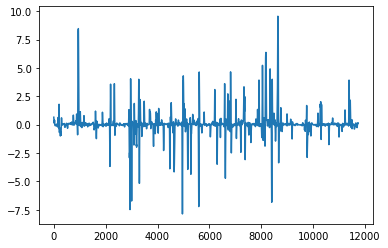

In [ ]:
import statsmodels.api as sm
cycle, trend = sm.tsa.filters.hpfilter(result.realized_spread_30s[result.realized_spread_30s.notna()], 500)
plt.plot(trend)

(array([  15.,   77.,  161.,   33., 6254., 4678.,   25.,  105.,  394.,
         196.]),
 array([243.325, 244.633, 245.941, 247.249, 248.557, 249.865, 251.173,
        252.481, 253.789, 255.097, 256.405]),
 <a list of 10 Patch objects>)

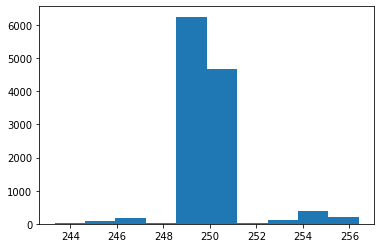

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

counts, bins = np.histogram(result.midquote[result.midquote.notna()])
plt.hist(bins[:-1], bins, weights=counts)

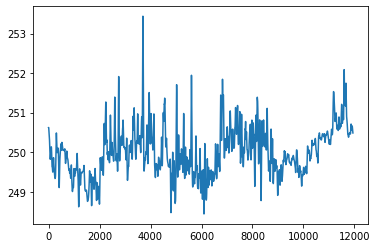

In [ ]:
import statsmodels.api as sm
cycle, trend = sm.tsa.filters.hpfilter(result.midquote[result.midquote.notna()], 5000)
plt.plot(trend)

(array([1.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 9.082e+03, 1.491e+03,
        1.240e+02, 2.020e+02, 4.720e+02, 1.600e+02]),
 array([-12.57 ,  -9.931,  -7.292,  -4.653,  -2.014,   0.625,   3.264,
          5.903,   8.542,  11.181,  13.82 ]),
 <a list of 10 Patch objects>)

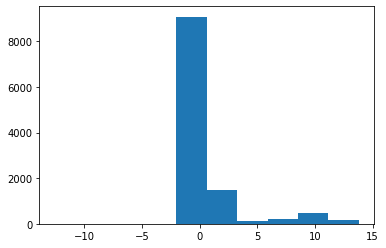

In [ ]:

counts, bins = np.histogram(result.effective_spread[result.effective_spread.notna()])
plt.hist(bins[:-1], bins, weights=counts)

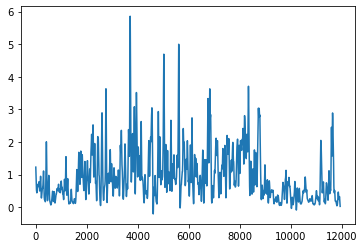

In [ ]:
import statsmodels.api as sm
cycle, trend = sm.tsa.filters.hpfilter(result.effective_spread[result.effective_spread.notna()], 10000)
plt.plot(trend)

(array([5702.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        5832.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

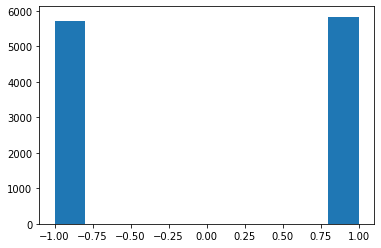

In [ ]:
counts, bins = np.histogram(result.d[result.d.notna()])
plt.hist(bins[:-1], bins, weights=counts)

{'boxes': [<matplotlib.lines.Line2D at 0x7ff75ad211d0>],
 'caps': [<matplotlib.lines.Line2D at 0x7ff75cff3c50>,
 'fliers': [<matplotlib.lines.Line2D at 0x7ff75da2e150>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7ff75b1d5bd0>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7ff75bc1f190>,
  <matplotlib.lines.Line2D at 0x7ff75d4cfed0>]}

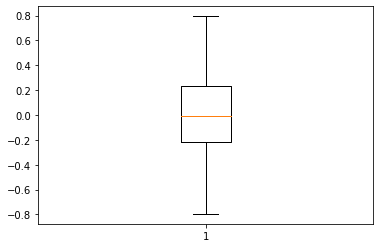

In [ ]:
import statsmodels.api as sm
cycle, trend = sm.tsa.filters.hpfilter(result.d[result.d.notna()], 10000)
plt.plot(trend)

(array([1.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 9.080e+03, 1.493e+03,
        1.040e+02, 2.160e+02, 4.720e+02, 1.660e+02]),
 array([-0.04906802, -0.03875719, -0.02844635, -0.01813552, -0.00782469,
         0.00248615,  0.01279698,  0.02310781,  0.03341865,  0.04372948,
         0.05404032]),
 <a list of 10 Patch objects>)

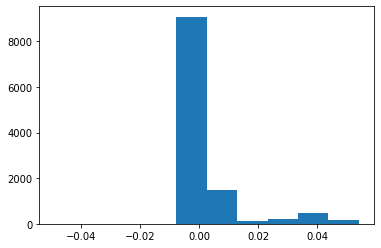

In [ ]:
counts, bins = np.histogram(result.relative_effective_spread[result.relative_effective_spread.notna()])
plt.hist(bins[:-1], bins, weights=counts)

In [ ]:
result.d[result.d.notna()]

(array([1.1699e+04, 1.4600e+02, 6.2000e+01, 1.8000e+01, 6.0000e+00,
        4.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([0.00000000e+00, 5.50557207e-07, 1.10111441e-06, 1.65167162e-06,
        2.20222883e-06, 2.75278604e-06, 3.30334324e-06, 3.85390045e-06,
        4.40445766e-06, 4.95501487e-06, 5.50557207e-06]),
 <a list of 10 Patch objects>)

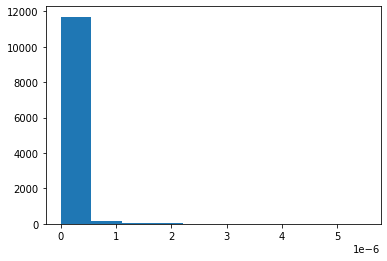

In [ ]:


counts, bins = np.histogram(result.illiquid_ratio[result.illiquid_ratio.notna()])
plt.hist(bins[:-1], bins, weights=counts)

In [ ]:
for i in range(10000000000):
  pass
print('finished')

finished


In [ ]:
df.columns

Index(['DATE', 'TIME_M', 'BID', 'BIDSIZ', 'ASK', 'ASKSIZ', 'SYM_ROOT',
       'SYM_SUFFIX'],
      dtype='object')

In [ ]:
df.isnull().value_counts()

DATE   TIME_M  BID    BIDSIZ  ASK    ASKSIZ  SYM_ROOT  SYM_SUFFIX
False  False   False  False   False  False   False     True          24804266
dtype: int64

In [ ]:
df

,DATE,TIME_M,BID,BIDSIZ,ASK,ASKSIZ,SYM_ROOT,SYM_SUFFIX
0,20190701,4:00:00.107346963,1450.00,1,0.00,0,AMZN,NaN
1,20190701,4:00:00.107347160,1450.00,2,0.00,0,AMZN,NaN
2,20190701,4:00:00.107522947,1450.00,2,1931.00,2,AMZN,NaN
3,20190701,4:00:00.107633493,1716.02,1,1931.00,2,AMZN,NaN
4,20190701,4:00:00.107633683,1801.00,1,1931.00,2,AMZN,NaN
...,...,...,...,...,...,...,...,...
7142091,20190930,19:58:34.715776245,1737.10,1,1739.08,1,AMZN,NaN
7142092,20190930,19:59:22.176415296,1737.40,5,1738.75,1,AMZN,NaN
7142093,20190930,19:59:26.790716125,1737.53,1,1738.75,1,AMZN,NaN
7142094,20190930,19:59:49.691360960,1736.00,1,1738.69,1,AMZN,NaN


(array([1.1019790e+06, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        2.1606845e+07, 2.0952320e+06, 4.1000000e+01, 1.6600000e+02,
        2.0000000e+00, 1.0000000e+00]),
 array([   0.   ,  401.423,  802.846, 1204.269, 1605.692, 2007.115,
        2408.538, 2809.961, 3211.384, 3612.807, 4014.23 ]),
 <a list of 10 Patch objects>)

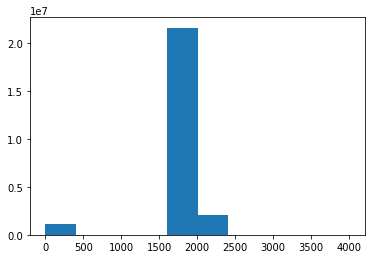

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

counts, bins = np.histogram(df.ASK)
plt.hist(bins[:-1], bins, weights=counts)